In [1]:
#import necessary packages
import astropy
import matplotlib.pyplot as plt
import numpy as np
import cv2
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

In [2]:
#open data file
hdul=fits.open("ukidss_gz2_rh_debiased.fits")

In [3]:
#get specific data
cols = hdul[1].columns
data = hdul[1].data
#get out the bad data, sift through it
#print(data["petromag_MR"])
spirals=data[data["t00_smooth_or_features_a1_features_debiased_rh_ukidss"]>0.5]
notedge=spirals[spirals["t01_disk_edge_on_a1_no_debiased_rh_ukidss"]>0.715]
Nnotedge=notedge[notedge['t01_disk_edge_on_count_weighted_ukidss']>20]
visiblespiral=Nnotedge[Nnotedge["t03_spiral_a0_spiral_debiased_rh_ukidss"]>0.5]
petromag=visiblespiral[visiblespiral["PETROMAG_MR"]<-19]
petromag=petromag[petromag["REDSHIFT"]<0.035]
#access each column

In [4]:
cols.info

<bound method ColDefs.info of ColDefs(
    name = 'dr7objid'; format = 'K'; null = -9223372036854775808
    name = 'dr8objid'; format = '19A'
    name = 'petrorad_r'; format = 'D'
    name = 'Ymag'; format = 'E'
    name = 'e_Ymag'; format = 'E'
    name = 'Jmag'; format = 'E'
    name = 'e_Jmag'; format = 'E'
    name = 'Hmag'; format = 'E'
    name = 'e_Hmag'; format = 'E'
    name = 'Kmag'; format = 'E'
    name = 'e_Kmag'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'UKIDSS_url'; format = '88A'
    name = 'GZ2_url'; format = '158A'
    name = 'subject_id'; format = '24A'
    name = 't00_smooth_or_features_a0_smooth_weighted_fraction_ukidss'; format = 'D'
    name = 't00_smooth_or_features_a1_features_weighted_fraction_ukidss'; format = 'D'
    name = 't00_smooth_or_features_a2_artifact_weighted_fraction_ukidss'; format = 'D'
    name = 't00_smooth_or_features_count_weighted_ukidss'; format = 'D'
    name = 't01_disk_edge_on_a0_yes_weighted_f

In [5]:
#set up variables w_mag and b_avg for IR:
w_mag=(0.5)*petromag["t09_arms_winding_a1_medium_debiased_rh_ukidss"]+1.0*petromag["t09_arms_winding_a0_tight_debiased_rh_ukidss"]
b_avg=0.2*petromag["t04_bulge_prominence_a1_just_noticeable_debiased_rh_ukidss"]+0.8*petromag["t04_bulge_prominence_a2_obvious_debiased_rh_ukidss"]+1.0*petromag["t04_bulge_prominence_a3_dominant_debiased_rh_ukidss"]

<function matplotlib.pyplot.show(*args, **kw)>

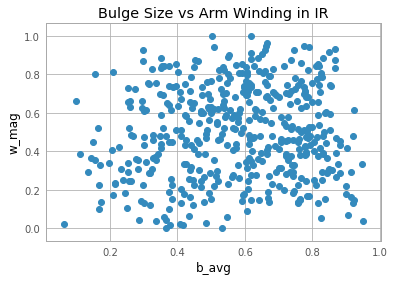

In [22]:
#attempt 11/22/19 at plotting data
sc=plt.scatter(b_avg,w_mag)
plt.xlabel("b_avg")
plt.ylabel("w_mag")
plt.title("Bulge Size vs Arm Winding in IR")
#cb = fig.colorbar((plt.hexbin(b_avg,w_mag)), ax=ax)
#cb.set_label('density')
plt.show

Comments on first attempt at plotting: not pretty, needs to be in a contour plot, also confused by the horizontal lines. 

Values are very discrete -- 

need to get out not good data
-pfeatures >0.5 to get rid of el
-pnotedgeon > 0.715
-Nnotedgeon>20
-Pspiral>0.5
Need to select:
rows where Pfeaters>0.5

In [30]:
#from contours import kde_contour

In [11]:
#fit plotter from Hubble_sequence/gz2_vs_data.ipynb from Karen


def fit_plotter(ax,x,y,xlabel='x',ylabel='y',sample_label='sample',ylims=(0,40),
                shortlabels='xy',color='b',spread=False):
    plt.sca(ax)
    _ = ax.set_xlabel(xlabel)
    _ = ax.set_ylabel(ylabel)
    _ = ax.set_xlim(-0.1,1.1)
    _ = ax.set_ylim(ylims)
    
    scatter_label = '{} ($N_\mathrm{{gal}}$={})'.format(sample_label,len(x))
    _ = ax.scatter(x,y,color='k',s=2,rasterized=True,zorder=0,
                label=scatter_label)
    _ = kde_contour(x,y,fill=True,zorder=1)
    xy = x_vs_y(x,y)
    xy = xy.continuous_vs_continuous_binned_mean(spread=spread)
    xy.error_plot(ax,style='errorbar',fmt='o',lw=2,color=color,capthick=2,zorder=3,capsize=3)

    x_guide = np.linspace(-1,2,100)
    p_fit, p_cov = curve_fit(linear,x,y)
    delta_p = np.sqrt(np.diag(p_cov))
    
    line_label = '${}={}\pm{}{} + {}\pm{}$'.format(shortlabels[0],np.round(p_fit[0],decimals=2),
                                         np.round(delta_p[0],decimals=2),
                                         shortlabels[1],np.round(p_fit[1],decimals=2),
                                         np.round(delta_p[1],decimals=2))
    _ = ax.plot(x_guide,linear(x_guide,*p_fit),
                color=color,lw=3,linestyle='dashed',zorder=2,
                label=line_label)

    _ = ax.legend(fontsize=15,loc='lower right')
    return None

In [34]:
#using code from Hubble_sequence/gz2_vs_data.ipynb from Karen
#ax = axarr[0]
#fig, ax(arr) = plt.figsize(20,10)
spread = False
#ax = ax


x = b_avg
y = w_mag
fit_plotter(ax,x,y,'b_avg','w_mag','bulge+armwinding',(0,40),('\psi','w_\mathrm{{avg}}'), color='b',spread=spread)
fig.plot

ValueError: Axes instance argument was not found in a figure

In [28]:
#found a python library called seaborn, lets play with that
import seaborn as sns
df = pd.DataFrame({'w_mag' : [w_mag],'b_avg' : [b_avg]})
sns.set_style("white")
sns.kdeplot(df.sepal_width, df.sepal_length)


AttributeError: 'DataFrame' object has no attribute 'sepal_width'

Update 2/7:

Continued trying to develop contour/density plot for arm winding vs bulge size. Seem to have figured out how to get color bar, need to play more. Unable to to get a proper label on the color bar. 

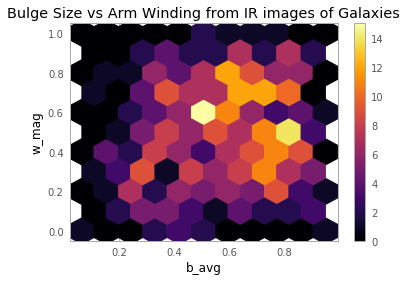

In [33]:
#plot of density with larger bin size (grid size)

hb = plt.hexbin(b_avg, w_mag, gridsize=10, cmap='inferno')
plt.xlabel('b_avg')
plt.ylabel('w_mag')

plt.title("Bulge Size vs Arm Winding from IR images of Galaxies")
cb=plt.colorbar(hb)

plt.show()

What does this say about the correlation or lack thereof between bulge size and arm winding? It does not support the idea that bulge size and arm winding are correlated becuase there is no linear or otherwise mathematical epxression to attachthe values to. 
Question: is the density plot I produced above actually showing me different/more relevent information than the initial scatter plot? 

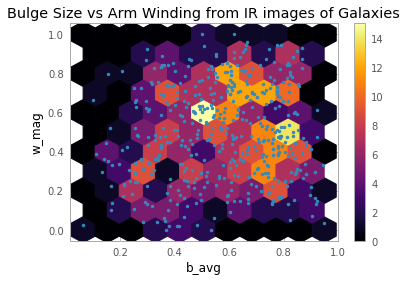

In [34]:
#density plot with initial scatter plot overlayed on top

hb = plt.hexbin(b_avg, w_mag, gridsize=10, cmap='inferno')
plt.xlabel('b_avg')
plt.ylabel('w_mag')
#plt.(xlim=(xmin, xmax), ylim=(ymin, ymax))
plt.title("Bulge Size vs Arm Winding from IR images of Galaxies")
cb=plt.colorbar(hb)
#cb.ylabel('counts')

#scatter plot from above
sc=plt.scatter(b_avg,w_mag, s=6)
plt.show()